### Segundo experimento de detecção de Alzermir com dois dataset

In [25]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kushagrasharma133/oasis-alzheimer-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/oasis-alzheimer-dataset


In [26]:
import os
import pandas as pd
import kagglehub
import io
from io import BytesIO
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torchvision import transforms, models
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time

# Mapeia os rótulos numéricos para nomes das classes (apenas para referência posterior)
label_map = {
    0: 'Mild_Dementia',
    1: 'Moderate_Dementia',
    2: 'Non_Demented',
    3: 'Very_mild_Dementia'
}

# Faz o download da versão mais recente do dataset via kagglehub
path = kagglehub.dataset_download("borhanitrash/alzheimer-mri-disease-classification-dataset")

# Mapeia os nomes das pastas para rótulos numéricos
class_map = {
    'Mild Dementia': 0,
    'Moderate Dementia': 1,
    'Non Demented': 2,
    'Very mild Dementia': 3
}

# Cria um dataframe a partir das imagens contidas nas pastas
def criar_dataframe_de_imagens(base_path, class_map, source_name):
    dados = []
    for label_nome, label_id in class_map.items():
        pasta = os.path.join(base_path, label_nome)
        if not os.path.exists(pasta):
            continue
        for nome_arquivo in os.listdir(pasta):
            caminho_completo = os.path.join(pasta, nome_arquivo)
            dados.append({
                'image_path': caminho_completo,
                'label': label_id,
                'source': source_name
            })
    return pd.DataFrame(dados)

# Carrega os dados de imagem das pastas (OASIS)
df_train_oasis = criar_dataframe_de_imagens(
    '/kaggle/input/oasis-alzheimer-dataset/train', class_map, 'oasis_train')
df_test_oasis = criar_dataframe_de_imagens(
    '/kaggle/input/oasis-alzheimer-dataset/test', class_map, 'oasis_test')

# Carrega os dados do arquivo Parquet
df_parquet = pd.read_parquet('/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet')

# Converte os bytes da imagem em objetos BytesIO (necessário para abrir com PIL)
df_parquet['image_path'] = df_parquet['image'].apply(lambda x: BytesIO(x['bytes']))

# Seleciona apenas as colunas necessárias e adiciona a coluna 'source'
df_parquet_final = df_parquet[['image_path', 'label']].copy()
df_parquet_final['source'] = 'parquet'

# Junta os três dataframes em um único dataframe geral
df_geral = pd.concat([df_parquet_final, df_train_oasis, df_test_oasis], ignore_index=True)

# Mostra a distribuição de amostras por fonte
print("\nDistribuição por fonte no df_geral:\n", df_geral['source'].value_counts())



Distribuição por fonte no df_geral:
 source
oasis_train    69148
oasis_test     17289
parquet         5120
Name: count, dtype: int64


In [27]:
# Cirar dataset customizado
class AlzheimerUnifiedDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.df = dataframe
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    entrada = self.df.iloc[idx]['image_path']
    label = self.df.iloc[idx]['label']

    # Se for caminho (string), abra a imagem
    if isinstance(entrada, str):
      image = Image.open(entrada).convert('RGB')
    else:
      image = Image.open(entrada).convert('RGB')

    if self.transform:
      image = self.transform(image)

    return image, label

In [28]:
# Split em treino, validação e teste
df_trainval, df_test = train_test_split(df_geral, test_size=0.15, stratify=df_geral['label'], random_state=42)
df_train, df_val = train_test_split(df_trainval, test_size=0.15, stratify=df_trainval['label'], random_state=42)

In [29]:
# Transforms padrão
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],    # padrão ImageNet
                        std=[0.229, 0.224, 0.225])
])



In [30]:
# Carregar os loaders
train_dataset = AlzheimerUnifiedDataset(df_train, transform=transform)
val_dataset = AlzheimerUnifiedDataset(df_val, transform=transform)
test_dataset = AlzheimerUnifiedDataset(df_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
# Modelo com AlexNet pré-treinado
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

# Substitui a camada final para 4 classes
# A AlexNet tem um classifier com vários Layers
# Vamos modificar a útltima camada linear (classifier[6])
model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 4)

# Colocar o modelo na GPU
model = model.to(device)

In [33]:
# Função de perda com pesos
weights = torch.tensor([0.0825, 0.8802, 0.0067, 0.0305]).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [34]:
# Treinamento
num_epochs = 10
train_losses, val_losses = [], []

star_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    y_train_true, y_train_pred = [], []

    for images, labels in tqdm(train_loader, desc=f'Época {epoch + 1}/{num_epochs} - Treino'):
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

      # Métricas treino
      _, preds = torch.max(outputs, 1)
      y_train_true.extend(labels.cpu().numpy())
      y_train_pred.extend(preds.cpu().numpy())

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    train_accuracy = accuracy_score(y_train_true, y_train_pred)
    train_precision = precision_score(y_train_true, y_train_pred, average='weighted', zero_division=0)
    train_recall = recall_score(y_train_true, y_train_pred, average='weighted', zero_division=0)
    train_f1 = f1_score(y_train_true, y_train_pred, average='weighted', zero_division=0)

    # Validação
    model.eval()
    val_loss = 0.0
    y_val_true, y_val_pred = [], []

    with torch.no_grad():
      for images, labels in tqdm(val_loader, desc=f'Época {epoch+1}/{num_epochs} - Validação'):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        # Métricas validação
        _, preds = torch.max(outputs, 1)
        y_val_true.extend(labels.cpu().numpy())
        y_val_pred.extend(preds.cpu().numpy())
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = accuracy_score(y_val_true, y_val_pred)
    val_precision = precision_score(y_val_true, y_val_pred, average='weighted', zero_division=0)
    val_recall = recall_score(y_val_true, y_val_pred, average='weighted', zero_division=0)
    val_f1 = f1_score(y_val_true, y_val_pred, average='weighted', zero_division=0)
    print(f"""
    Época {epoch+1}/{num_epochs}
    ----------------------------
    Treino:
    Loss: {avg_train_loss:.4f}
    Acurácia: {train_accuracy:.4f}
    Precisão: {train_precision:.4f}
    Recall: {train_recall:.4f}
    F1 Score: {train_f1:.4f}
    Validação:
    Loss: {avg_val_loss:.4f}
    Acurácia: {val_accuracy:.4f}
    Precisão: {val_precision:.4f}
    Recall: {val_recall:.4f}
    F1 Score: {val_f1:.4f}
    """)

end_time = time.time()
execution_time = end_time - star_time
print(f"Tempo de execução: {execution_time} segundos")

Época 1/10 - Validação: 100%|██████████| 730/730 [00:45<00:00, 16.11it/s]



    Época 1/10
    ----------------------------
    Treino:
    Loss: 0.8817
    Acurácia: 0.6626
    Precisão: 0.7924
    Recall: 0.6626
    F1 Score: 0.7037
    Validação:
    Loss: 0.4434
    Acurácia: 0.7974
    Precisão: 0.8584
    Recall: 0.7974
    F1 Score: 0.8148
    


Época 2/10 - Validação: 100%|██████████| 730/730 [00:43<00:00, 16.64it/s]



    Época 2/10
    ----------------------------
    Treino:
    Loss: 0.4120
    Acurácia: 0.8208
    Precisão: 0.8759
    Recall: 0.8208
    F1 Score: 0.8352
    Validação:
    Loss: 0.2053
    Acurácia: 0.9017
    Precisão: 0.9277
    Recall: 0.9017
    F1 Score: 0.9078
    


Época 3/10 - Validação: 100%|██████████| 730/730 [00:44<00:00, 16.25it/s]



    Época 3/10
    ----------------------------
    Treino:
    Loss: 0.2609
    Acurácia: 0.8924
    Precisão: 0.9153
    Recall: 0.8924
    F1 Score: 0.8984
    Validação:
    Loss: 0.1482
    Acurácia: 0.9423
    Precisão: 0.9542
    Recall: 0.9423
    F1 Score: 0.9449
    


Época 4/10 - Validação: 100%|██████████| 730/730 [00:44<00:00, 16.40it/s]



    Época 4/10
    ----------------------------
    Treino:
    Loss: 0.2202
    Acurácia: 0.9158
    Precisão: 0.9307
    Recall: 0.9158
    F1 Score: 0.9199
    Validação:
    Loss: 0.1529
    Acurácia: 0.9370
    Precisão: 0.9504
    Recall: 0.9370
    F1 Score: 0.9399
    


Época 5/10 - Validação: 100%|██████████| 730/730 [00:44<00:00, 16.39it/s]



    Época 5/10
    ----------------------------
    Treino:
    Loss: 0.1949
    Acurácia: 0.9249
    Precisão: 0.9380
    Recall: 0.9249
    F1 Score: 0.9286
    Validação:
    Loss: 0.1435
    Acurácia: 0.9330
    Precisão: 0.9459
    Recall: 0.9330
    F1 Score: 0.9363
    


Época 6/10 - Validação: 100%|██████████| 730/730 [00:44<00:00, 16.30it/s]



    Época 6/10
    ----------------------------
    Treino:
    Loss: 0.1877
    Acurácia: 0.9284
    Precisão: 0.9400
    Recall: 0.9284
    F1 Score: 0.9316
    Validação:
    Loss: 0.1314
    Acurácia: 0.9465
    Precisão: 0.9577
    Recall: 0.9465
    F1 Score: 0.9489
    


Época 7/10 - Validação: 100%|██████████| 730/730 [00:44<00:00, 16.30it/s]



    Época 7/10
    ----------------------------
    Treino:
    Loss: 0.1605
    Acurácia: 0.9387
    Precisão: 0.9488
    Recall: 0.9387
    F1 Score: 0.9416
    Validação:
    Loss: 0.1934
    Acurácia: 0.8921
    Precisão: 0.9242
    Recall: 0.8921
    F1 Score: 0.8986
    


Época 8/10 - Validação: 100%|██████████| 730/730 [00:44<00:00, 16.33it/s]



    Época 8/10
    ----------------------------
    Treino:
    Loss: 0.2400
    Acurácia: 0.9168
    Precisão: 0.9320
    Recall: 0.9168
    F1 Score: 0.9210
    Validação:
    Loss: 0.1369
    Acurácia: 0.9600
    Precisão: 0.9661
    Recall: 0.9600
    F1 Score: 0.9612
    


Época 9/10 - Validação: 100%|██████████| 730/730 [00:46<00:00, 15.86it/s]



    Época 9/10
    ----------------------------
    Treino:
    Loss: 0.1709
    Acurácia: 0.9365
    Precisão: 0.9460
    Recall: 0.9365
    F1 Score: 0.9391
    Validação:
    Loss: 0.1432
    Acurácia: 0.9556
    Precisão: 0.9613
    Recall: 0.9556
    F1 Score: 0.9570
    


Época 10/10 - Validação: 100%|██████████| 730/730 [00:43<00:00, 16.90it/s]


    Época 10/10
    ----------------------------
    Treino:
    Loss: 0.1782
    Acurácia: 0.9362
    Precisão: 0.9457
    Recall: 0.9362
    F1 Score: 0.9387
    Validação:
    Loss: 0.1512
    Acurácia: 0.9513
    Precisão: 0.9571
    Recall: 0.9513
    F1 Score: 0.9527
    
Tempo de execução: 3934.6507346630096 segundos


In [38]:
from sklearn.metrics import confusion_matrix

# Matriz de confusão para treino
cm_train = confusion_matrix(y_train_true, y_train_pred)
print("Matriz de Confusão - Treino:")
print(cm_train)

# Matriz de confusão para validação
cm_val = confusion_matrix(y_val_true, y_val_pred)
print("\nMatriz de Confusão - Validação:")
print(cm_val)


Matriz de Confusão - Treino:
[[ 3728    10    45   354]
 [   18   354     3    13]
 [  975    29 47254  2163]
 [  402    30   181 10590]]

Matriz de Confusão - Validação:
[[ 655    0    1   74]
 [   0   62    0    6]
 [  89    0 8467  343]
 [  12    1   43 1921]]


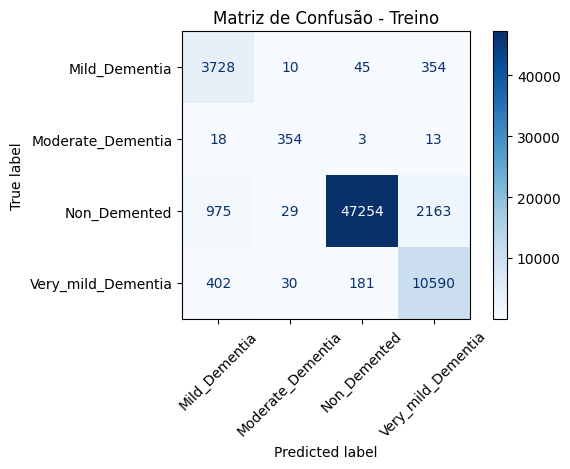

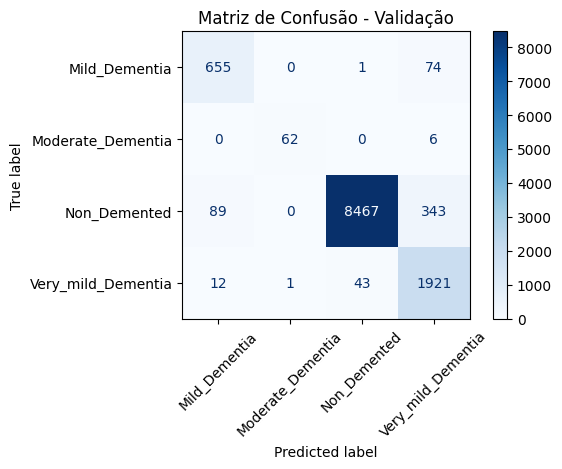

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Matriz de confusão - Treino
cm_train = confusion_matrix(y_train_true, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=list(label_map.values()))
disp_train.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Matriz de Confusão - Treino")
plt.tight_layout()
plt.show()

# Matriz de confusão - Validação
cm_val = confusion_matrix(y_val_true, y_val_pred)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=list(label_map.values()))
disp_val.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Matriz de Confusão - Validação")
plt.tight_layout()
plt.show()


In [36]:
import numpy as np
from collections import Counter

# Conta os rótulos no dataset completo (ou só no treino, se preferir)
labels_all = df_geral['label'].values  # ou apenas y_train, se já separado
class_counts = Counter(labels_all)

# Número total de amostras
total_samples = sum(class_counts.values())

# Calcula pesos inversamente proporcionais
class_weights = []
for i in range(len(label_map)):  # 4 classes
    freq = class_counts[i] / total_samples
    weight = 1.0 / freq
    class_weights.append(weight)

# Normaliza para evitar números grandes
class_weights = np.array(class_weights)
class_weights = class_weights / class_weights.sum()

print("Contagem por classe:", class_counts)
print("Pesos normalizados por classe:", class_weights)


# Converte para tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Cria o criterion ponderado
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

Contagem por classe: Counter({2: 69788, 3: 15506, 0: 5726, 1: 537})
Pesos normalizados por classe: [0.0825473  0.88019705 0.00677288 0.03048277]
